In [3]:

import os
import sys
import io
import matplotlib.pyplot as plt
sys.path.append("C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/train/vint_train")

# pytorch
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.transforms.functional as TF

import numpy as np
from PIL import Image as PILImage
from typing import List, Tuple, Dict, Optional

# models
from vint_train.models.gnm.gnm import GNM
from vint_train.models.vint.vint import ViNT

from vint_train.models.vint.vit import ViT
from vint_train.models.nomad.nomad import NoMaD, DenseNetwork
from vint_train.models.nomad.nomad_vint import NoMaD_ViNT, replace_bn_with_gn
from diffusion_policy.model.diffusion.conditional_unet1d import ConditionalUnet1D
from vint_train.data.data_utils import IMAGE_ASPECT_RATIO


def load_model(
    model_path: str,
    config: dict,
    device: torch.device = torch.device("cpu"),
) -> nn.Module:
    """Load a model from a checkpoint file (works with models trained on multiple GPUs)"""
    model_type = config["model_type"]
    
    if model_type == "gnm":
        model = GNM(
            config["context_size"],
            config["len_traj_pred"],
            config["learn_angle"],
            config["obs_encoding_size"],
            config["goal_encoding_size"],
        )
    elif model_type == "vint":
        model = ViNT(
            context_size=config["context_size"],
            len_traj_pred=config["len_traj_pred"],
            learn_angle=config["learn_angle"],
            obs_encoder=config["obs_encoder"],
            obs_encoding_size=config["obs_encoding_size"],
            late_fusion=config["late_fusion"],
            mha_num_attention_heads=config["mha_num_attention_heads"],
            mha_num_attention_layers=config["mha_num_attention_layers"],
            mha_ff_dim_factor=config["mha_ff_dim_factor"],
        )
    elif config["model_type"] == "nomad":
        if config["vision_encoder"] == "nomad_vint":
            vision_encoder = NoMaD_ViNT(
                obs_encoding_size=config["encoding_size"],
                context_size=config["context_size"],
                mha_num_attention_heads=config["mha_num_attention_heads"],
                mha_num_attention_layers=config["mha_num_attention_layers"],
                mha_ff_dim_factor=config["mha_ff_dim_factor"],
            )
            vision_encoder = replace_bn_with_gn(vision_encoder)
        elif config["vision_encoder"] == "vit": 
            vision_encoder = ViT(
                obs_encoding_size=config["encoding_size"],
                context_size=config["context_size"],
                image_size=config["image_size"],
                patch_size=config["patch_size"],
                mha_num_attention_heads=config["mha_num_attention_heads"],
                mha_num_attention_layers=config["mha_num_attention_layers"],
            )
            vision_encoder = replace_bn_with_gn(vision_encoder)
        else: 
            raise ValueError(f"Vision encoder {config['vision_encoder']} not supported")
        
        noise_pred_net = ConditionalUnet1D(
                input_dim=2,
                global_cond_dim=config["encoding_size"],
                down_dims=config["down_dims"],
                cond_predict_scale=config["cond_predict_scale"],
            )
        dist_pred_network = DenseNetwork(embedding_dim=config["encoding_size"])
        
        model = NoMaD(
            vision_encoder=vision_encoder,
            noise_pred_net=noise_pred_net,
            dist_pred_net=dist_pred_network,
        )
    else:
        raise ValueError(f"Invalid model type: {model_type}")
    
    checkpoint = torch.load(model_path, map_location=device)
    if model_type == "nomad":
        state_dict = checkpoint
        model.load_state_dict(state_dict, strict=False)
    else:
        loaded_model = checkpoint["model"]
        try:
            state_dict = loaded_model.module.state_dict()
            model.load_state_dict(state_dict, strict=False)
        except AttributeError as e:
            state_dict = loaded_model.state_dict()
            model.load_state_dict(state_dict, strict=False)
    model.to(device)
    return model



In [4]:
import torch
import os
import yaml
from pathlib import Path


# Define the path to the YAML configuration files and model weights
MODEL_WEIGHTS_PATH = "C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/deployment/model_weights"
MODEL_CONFIG_PATH = "C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/deployment/config/models.yaml"

# Load the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model configuration from YAML
with open(MODEL_CONFIG_PATH, "r") as f:
    model_paths = yaml.safe_load(f)

# Specify the model to load (assuming "nomad" in this case)
model_name = "nomad"
model_config_path = "C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/train/config/nomad.yaml"
print(f"Loading model configuration from {model_config_path}")
with open(model_config_path, "r") as f:
    model_params = yaml.safe_load(f)

# Load model weights from the checkpoint file
ckpth_path = model_paths[model_name]["ckpt_path"]
if os.path.exists(ckpth_path):
    print(f"Loading model from {ckpth_path}")
else:
    raise FileNotFoundError(f"Model weights not found at {ckpth_path}")

# Assuming load_model is a utility function available in the utils module
sys.path.append(("C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/deployment/src"))
from utils1 import load_model


# Load the model
model = load_model(ckpth_path, model_params, device)
model = model.to(device)
model.eval()

print("Model loaded successfully!")
print(model)


Using device: cpu
Loading model configuration from C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/train/config/nomad.yaml
Loading model from C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/deployment/model_weights/nomad.pth


ImportError: attempted relative import with no known parent package

In [ ]:
import torch
image = torch.zeros((1, 3,85,64))
obsgoal_cond = model('vision_encoder', obs_img=image,goal_img = image, input_goal_mask= image)


RuntimeError: Given groups=1, weight of size [32, 6, 3, 3], expected input[1, 3, 86, 65] to have 6 channels, but got 3 channels instead

In [ ]:
import time
import torch
import os
import yaml
from pathlib import Path


from diffusion_policy.model.diffusion.conditional_unet1d import ConditionalUnet1D
from vint_train.models.gnm.gnm import GNM
from vint_train.models.nomad.nomad import DenseNetwork, NoMaD
from vint_train.models.nomad.nomad_vint import NoMaD_ViNT, replace_bn_with_gn
from vint_train.models.vint.vint import ViNT
from vint_train.models.vint.vit import ViT

from diffusers.schedulers.scheduling_ddpm import DDPMScheduler



# Define the path to the YAML configuration files and model weights
MODEL_WEIGHTS_PATH = "C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/deployment/model_weights"
MODEL_CONFIG_PATH = "C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/deployment/config/models.yaml"

# Load the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model configuration from YAML
with open(MODEL_CONFIG_PATH, "r") as f:
    model_paths = yaml.safe_load(f)

# Specify the model to load (assuming "nomad" in this case)
model_name = "nomad"
model_config_path = "C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/train/config/nomad.yaml"
print(f"Loading model configuration from {model_config_path}")
with open(model_config_path, "r") as f:
    model_params = yaml.safe_load(f)

# Load model weights from the checkpoint file
ckpth_path = model_paths[model_name]["ckpt_path"]
if os.path.exists(ckpth_path):
    print(f"Loading model from {ckpth_path}")
else:
    raise FileNotFoundError(f"Model weights not found at {ckpth_path}")


def load_model(
    model_path: str,
    config: dict,
    device: torch.device = torch.device("cpu"),
) -> torch.nn.Module:
    """Load a model from a checkpoint file (works with models trained on multiple GPUs)"""
    model_type = config["model_type"]
    
    if model_type == "gnm":
        model = GNM(
            config["context_size"],
            config["len_traj_pred"],
            config["learn_angle"],
            config["obs_encoding_size"],
            config["goal_encoding_size"],
        )
    elif model_type == "vint":
        model = ViNT(
            context_size=config["context_size"],
            len_traj_pred=config["len_traj_pred"],
            learn_angle=config["learn_angle"],
            obs_encoder=config["obs_encoder"],
            obs_encoding_size=config["obs_encoding_size"],
            late_fusion=config["late_fusion"],
            mha_num_attention_heads=config["mha_num_attention_heads"],
            mha_num_attention_layers=config["mha_num_attention_layers"],
            mha_ff_dim_factor=config["mha_ff_dim_factor"],
        )
    elif config["model_type"] == "nomad":
        if config["vision_encoder"] == "nomad_vint":
            vision_encoder = NoMaD_ViNT(
                obs_encoding_size=config["encoding_size"],
                context_size=config["context_size"],
                mha_num_attention_heads=config["mha_num_attention_heads"],
                mha_num_attention_layers=config["mha_num_attention_layers"],
                mha_ff_dim_factor=config["mha_ff_dim_factor"],
            )
            vision_encoder = replace_bn_with_gn(vision_encoder)
        elif config["vision_encoder"] == "vit": 
            vision_encoder = ViT(
                obs_encoding_size=config["encoding_size"],
                context_size=config["context_size"],
                image_size=config["image_size"],
                patch_size=config["patch_size"],
                mha_num_attention_heads=config["mha_num_attention_heads"],
                mha_num_attention_layers=config["mha_num_attention_layers"],
            )
            vision_encoder = replace_bn_with_gn(vision_encoder)
        else: 
            raise ValueError(f"Vision encoder {config['vision_encoder']} not supported")
        
        noise_pred_net = ConditionalUnet1D(
                input_dim=2,
                global_cond_dim=config["encoding_size"],
                down_dims=config["down_dims"],
                cond_predict_scale=config["cond_predict_scale"],
            )
        dist_pred_network = DenseNetwork(embedding_dim=config["encoding_size"])
        
        model = NoMaD(
            vision_encoder=vision_encoder,
            noise_pred_net=noise_pred_net,
            dist_pred_net=dist_pred_network,
        )
    else:
        raise ValueError(f"Invalid model type: {model_type}")
    
    checkpoint = torch.load(model_path, map_location=device)
    if model_type == "nomad":
        state_dict = checkpoint
        model.load_state_dict(state_dict, strict=False)
    else:
        loaded_model = checkpoint["model"]
        try:
            state_dict = loaded_model.module.state_dict()
            model.load_state_dict(state_dict, strict=False)
        except AttributeError as e:
            state_dict = loaded_model.state_dict()
            model.load_state_dict(state_dict, strict=False)
    model.to(device)
    return model



# Load the model
model = load_model(ckpth_path, model_params, device)
model = model.to(device)
model.eval()

import torch
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((85, 64)),      # Resize to 85x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])         # Convert to a tensor with shape (3, 85, 64)
])
image1 = transform(Image.open("C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/Webot_Pictures/1/camera_image10.png").convert("RGB"))
image2 = transform(Image.open("C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/Webot_Pictures/1/camera_image20.png").convert("RGB"))
image3 = transform(Image.open("C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/Webot_Pictures/1/camera_image30.png").convert("RGB"))
image4 = transform(Image.open("C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/Webot_Pictures/1/camera_image40.png").convert("RGB"))
image = torch.stack([image1,image2,image3,image4], dim=0).permute(1, 0, 2, 3).reshape(1, 12, 85, 64)

#image = torch.zeros((1, 12,85,64))
goal = torch.zeros((1, 3,85,64))
obsgoal_cond = model('vision_encoder', obs_img=image,goal_img = goal, input_goal_mask= None)
dists = model("dist_pred_net", obsgoal_cond=obsgoal_cond)
#infere Action
noise_scheduler = DDPMScheduler(
            num_train_timesteps=model_params["num_diffusion_iters"],
            beta_schedule='squaredcos_cap_v2',
            clip_sample=True,
            prediction_type='epsilon'
        )
obs_cond = obsgoal_cond
num_samples = 1
with torch.no_grad():
    # encoder vision features
    if len(obs_cond.shape) == 2:
        obs_cond = obs_cond.repeat(num_samples, 1)
    else:
        obs_cond = obs_cond.repeat(num_samples, 1, 1)
    
    # initialize action from Gaussian noise
    noisy_action = torch.randn(
        (num_samples, model_params["len_traj_pred"], 2), device=device)
    naction = noisy_action

    # init scheduler
    noise_scheduler.set_timesteps(model_params["num_diffusion_iters"])

    start_time = time.time()
    for k in noise_scheduler.timesteps[:]:
        # predict noise
        noise_pred = model(
            'noise_pred_net',
            sample=naction,
            timestep=k,
            global_cond=obs_cond
        )
        # inverse diffusion step (remove noise)
        naction = noise_scheduler.step(
            model_output=noise_pred,
            timestep=k,
            sample=naction
        ).prev_sample
    print("time elapsed:", time.time() - start_time)
from matplotlib import pyplot as plt
plt.scatter(naction[0, :, 0].cpu().numpy(), naction[0, :, 1].cpu().numpy())
plt.show()
print("Model loaded successfully!")
print(model)


c:\Users\levid\anaconda3\envs\nomad_train\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'args' is not defined

Using device: cpu
Loading model configuration from C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/train/config/nomad.yaml
Loading model from C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/deployment/model_weights/nomad.pth
time elapsed: 0.32105469703674316


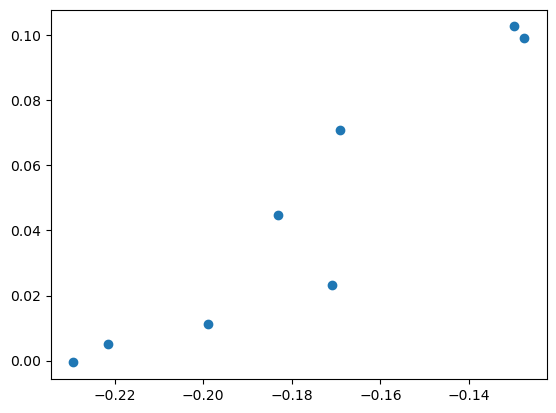

[[[ 3.8999707e-01 -2.2153854e-03]
  [ 8.0978990e-01  1.8138885e-02]
  [ 1.3135797e+00  6.3529015e-02]
  [ 1.9222124e+00  1.5610027e-01]
  [ 2.4856610e+00  3.3504343e-01]
  [ 3.1018729e+00  6.1886692e-01]
  [ 3.8647082e+00  1.0294118e+00]
  [ 4.6364422e+00  1.4260612e+00]]]


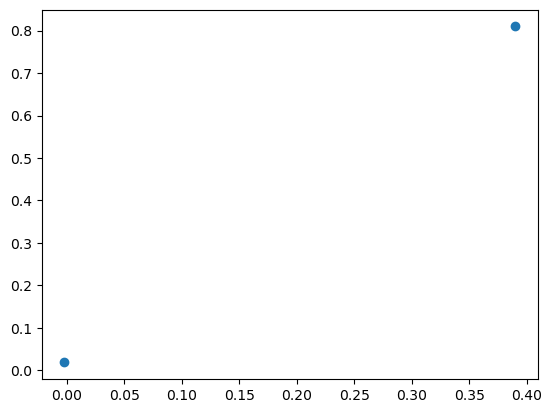

Model loaded successfully!
NoMaD(
  (vision_encoder): NoMaD_ViNT(
    (obs_encoder): EfficientNet(
      (_conv_stem): Conv2dStaticSamePadding(
        3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
        (static_padding): ZeroPad2d((0, 1, 0, 1))
      )
      (_bn0): GroupNorm(2, 32, eps=1e-05, affine=True)
      (_blocks): ModuleList(
        (0): MBConvBlock(
          (_depthwise_conv): Conv2dStaticSamePadding(
            32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
            (static_padding): ZeroPad2d((1, 1, 1, 1))
          )
          (_bn1): GroupNorm(2, 32, eps=1e-05, affine=True)
          (_se_reduce): Conv2dStaticSamePadding(
            32, 8, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_se_expand): Conv2dStaticSamePadding(
            8, 32, kernel_size=(1, 1), stride=(1, 1)
            (static_padding): Identity()
          )
          (_project_conv): Conv2dStaticSamePadding(
         

In [14]:
import time
import torch
import os
import yaml
from pathlib import Path

from std_msgs.msg import Bool, Float32MultiArray
from diffusion_policy.model.diffusion.conditional_unet1d import ConditionalUnet1D
from vint_train.models.gnm.gnm import GNM
from vint_train.models.nomad.nomad import DenseNetwork, NoMaD
from vint_train.models.nomad.nomad_vint import NoMaD_ViNT, replace_bn_with_gn
from vint_train.models.vint.vint import ViNT
from vint_train.models.vint.vit import ViT
from vint_train.training.train_utils import get_action
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler



# Define the path to the YAML configuration files and model weights
MODEL_WEIGHTS_PATH = "C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/deployment/model_weights"
MODEL_CONFIG_PATH = "C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/deployment/config/models.yaml"

# Load the device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load model configuration from YAML
with open(MODEL_CONFIG_PATH, "r") as f:
    model_paths = yaml.safe_load(f)

# Specify the model to load (assuming "nomad" in this case)
model_name = "nomad"
model_config_path = "C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/model/visualnav-transformer-main/train/config/nomad.yaml"
print(f"Loading model configuration from {model_config_path}")
with open(model_config_path, "r") as f:
    model_params = yaml.safe_load(f)

# Load model weights from the checkpoint file
ckpth_path = model_paths[model_name]["ckpt_path"]
if os.path.exists(ckpth_path):
    print(f"Loading model from {ckpth_path}")
else:
    raise FileNotFoundError(f"Model weights not found at {ckpth_path}")

def to_numpy(tensor):
    return tensor.cpu().detach().numpy()

def load_model(
    model_path: str,
    config: dict,
    device: torch.device = torch.device("cpu"),
) -> torch.nn.Module:
    """Load a model from a checkpoint file (works with models trained on multiple GPUs)"""
    model_type = config["model_type"]
    
    if model_type == "gnm":
        model = GNM(
            config["context_size"],
            config["len_traj_pred"],
            config["learn_angle"],
            config["obs_encoding_size"],
            config["goal_encoding_size"],
        )
    elif model_type == "vint":
        model = ViNT(
            context_size=config["context_size"],
            len_traj_pred=config["len_traj_pred"],
            learn_angle=config["learn_angle"],
            obs_encoder=config["obs_encoder"],
            obs_encoding_size=config["obs_encoding_size"],
            late_fusion=config["late_fusion"],
            mha_num_attention_heads=config["mha_num_attention_heads"],
            mha_num_attention_layers=config["mha_num_attention_layers"],
            mha_ff_dim_factor=config["mha_ff_dim_factor"],
        )
    elif config["model_type"] == "nomad":
        if config["vision_encoder"] == "nomad_vint":
            vision_encoder = NoMaD_ViNT(
                obs_encoding_size=config["encoding_size"],
                context_size=config["context_size"],
                mha_num_attention_heads=config["mha_num_attention_heads"],
                mha_num_attention_layers=config["mha_num_attention_layers"],
                mha_ff_dim_factor=config["mha_ff_dim_factor"],
            )
            vision_encoder = replace_bn_with_gn(vision_encoder)
        elif config["vision_encoder"] == "vit": 
            vision_encoder = ViT(
                obs_encoding_size=config["encoding_size"],
                context_size=config["context_size"],
                image_size=config["image_size"],
                patch_size=config["patch_size"],
                mha_num_attention_heads=config["mha_num_attention_heads"],
                mha_num_attention_layers=config["mha_num_attention_layers"],
            )
            vision_encoder = replace_bn_with_gn(vision_encoder)
        else: 
            raise ValueError(f"Vision encoder {config['vision_encoder']} not supported")
        
        noise_pred_net = ConditionalUnet1D(
                input_dim=2,
                global_cond_dim=config["encoding_size"],
                down_dims=config["down_dims"],
                cond_predict_scale=config["cond_predict_scale"],
            )
        dist_pred_network = DenseNetwork(embedding_dim=config["encoding_size"])
        
        model = NoMaD(
            vision_encoder=vision_encoder,
            noise_pred_net=noise_pred_net,
            dist_pred_net=dist_pred_network,
        )
    else:
        raise ValueError(f"Invalid model type: {model_type}")
    
    checkpoint = torch.load(model_path, map_location=device)
    if model_type == "nomad":
        state_dict = checkpoint
        model.load_state_dict(state_dict, strict=False)
    else:
        loaded_model = checkpoint["model"]
        try:
            state_dict = loaded_model.module.state_dict()
            model.load_state_dict(state_dict, strict=False)
        except AttributeError as e:
            state_dict = loaded_model.state_dict()
            model.load_state_dict(state_dict, strict=False)
    model.to(device)
    return model



# Load the model
model = load_model(ckpth_path, model_params, device)
model = model.to(device)
model.eval()

import torch
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((85, 64)),      # Resize to 85x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])              # Convert to a tensor with shape (3, 85, 64)
])
#image1 = transform(Image.open("../../go_stanford/go_stanford/no1vcF_7_1/93.jpg").convert("RGB"))
#image2 = transform(Image.open("../../go_stanford/go_stanford/no1vcF_7_1/94.jpg").convert("RGB"))
#image3 = transform(Image.open("../../go_stanford/go_stanford/no1vcF_7_1/95.jpg").convert("RGB"))
#image4 = transform(Image.open("../../go_stanford/go_stanford/no1vcF_7_1/96.jpg").convert("RGB"))
image1 = transform(Image.open("C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/Webot_Pictures/1/camera_image350.png").convert("RGB"))
image2 = transform(Image.open("C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/Webot_Pictures/1/camera_image360.png").convert("RGB"))
image3 = transform(Image.open("C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/Webot_Pictures/1/camera_image370.png").convert("RGB"))
image4 = transform(Image.open("C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/Webot_Pictures/1/camera_image380.png").convert("RGB"))
image = torch.stack([image1,image2,image3,image4], dim=0).permute(1, 0, 2, 3).reshape(1, 12, 85, 64)

#image = torch.zeros((1, 12,85,64))
goal = torch.zeros((1, 3,85,64))
obsgoal_cond = model('vision_encoder', obs_img=image,goal_img = goal, input_goal_mask= None)
dists = model("dist_pred_net", obsgoal_cond=obsgoal_cond)
#infere Action
noise_scheduler = DDPMScheduler(
            num_train_timesteps=model_params["num_diffusion_iters"],
            beta_schedule='squaredcos_cap_v2',
            clip_sample=True,
            prediction_type='epsilon'
        )
obs_cond = obsgoal_cond
num_samples = 1
with torch.no_grad():
    # encoder vision features
    if len(obs_cond.shape) == 2:
        obs_cond = obs_cond.repeat(num_samples, 1)
    else:
        obs_cond = obs_cond.repeat(num_samples, 1, 1)
    
    # initialize action from Gaussian noise
    noisy_action = torch.randn(
        (num_samples, model_params["len_traj_pred"], 2), device=device)
    naction = noisy_action

    # init scheduler
    noise_scheduler.set_timesteps(model_params["num_diffusion_iters"])

    start_time = time.time()
    for k in noise_scheduler.timesteps[:]:
        # predict noise
        noise_pred = model(
            'noise_pred_net',
            sample=naction,
            timestep=k,
            global_cond=obs_cond
        )
        # inverse diffusion step (remove noise)
        naction = noise_scheduler.step(
            model_output=noise_pred,
            timestep=k,
            sample=naction
        ).prev_sample
    print("time elapsed:", time.time() - start_time)
naction2 = to_numpy(get_action(naction))
sampled_actions_msg = Float32MultiArray()
sampled_actions_msg.data = np.concatenate((np.array([0]), naction2.flatten()))


from matplotlib import pyplot as plt
plt.scatter(naction[0, :, 0].cpu().numpy(), naction[0, :, 1].cpu().numpy())
plt.show()

print(naction2)

plt.scatter(naction2[:, 0], naction2[:, 1])
plt.show()
print("Model loaded successfully!")
print(model)


In [9]:
print(naction)
print(naction2)
print(naction2.shape)

tensor([[[-0.0520, -0.0041],
         [-0.0654, -0.0027],
         [-0.0866,  0.0022],
         [-0.0996,  0.0090],
         [-0.0714,  0.0078],
         [-0.0813,  0.0236],
         [-0.0848,  0.0532],
         [-0.0905,  0.0659]]])
[[[ 1.0548863  -0.01628208]
  [ 2.0597267  -0.02714419]
  [ 2.9849796  -0.01840138]
  [ 3.8614616   0.01766801]
  [ 4.8437643   0.04871869]
  [ 5.788789    0.1429193 ]
  [ 6.7206035   0.35579848]
  [ 7.631062    0.61927676]]]
(1, 8, 2)


In [15]:
import cv2

# Bild laden
img = cv2.imread("C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/Webot_Pictures/1/camera_image390.png")  # Ersetze 'dein_bild.jpg' durch den Pfad zu deinem Bild

coordinates = naction2


# Bilddimensionen und Ursprung (untere Mitte des Bildes)
image_width, image_height = img.shape[1], img.shape[0]
start_point = (image_width // 2, image_height//2)  # Untere Mitte

# Transformiere Koordinaten relativ zur unteren Mitte
absolute_coordinates = [start_point]  # Die erste Koordinate ist der Startpunkt
for coord in coordinates[0]:
    x = int(start_point[0] + coord[0] * image_width / 100)  # Skaliere x relativ zur Mitte
    y = int(start_point[1] + coord[1] * image_height / 100)  # Skaliere y nach oben
    absolute_coordinates.append((x, y))

# Zeichne Linien zwischen den Koordinaten
#for i in range(len(absolute_coordinates) - 1):
    #start_point = absolute_coordinates[i]
end_point = absolute_coordinates[- 1]
cv2.line(img, start_point, end_point, (0, 255, 0), 2)  # Grüne Linien


# Bild hochskalieren
upscale_factor = 4  # Faktor zur Vergrößerung
new_width = img.shape[1] * upscale_factor
new_height = img.shape[0] * upscale_factor
upscaled_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

# Bild anzeigen
cv2.imshow("Pfeile auf Bild", upscaled_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
import cv2

# Bild laden
img = cv2.imread("C:/Users/levid/Desktop/Uni/Master/SoSe24/ProjektLearningRobots/Webot_Pictures/1/camera_image10.png")  # Ersetze 'dein_bild.jpg' durch den Pfad zu deinem Bild

coordinates = naction2

image_width, image_height = img.shape[1], img.shape[0]
start_point = (image_width // 2, image_height)  # Untere Mitte

# Transformiere Koordinaten relativ zur unteren Mitte
absolute_coordinates = [start_point]  # Die erste Koordinate ist der Startpunkt
for coord in coordinates[0]:
    x = int(start_point[0] + coord[0] * image_width / 10)  # Skaliere x relativ zur Mitte
    y = int(start_point[1] - coord[1] * image_height / 10)  # Skaliere y nach oben
    absolute_coordinates.append((x, y))

# Zeichne Linien (blau für den Hauptpfad, gelb für alternative Pfade)
for i in range(len(absolute_coordinates) - 1):
    start_point = absolute_coordinates[i]
    end_point = absolute_coordinates[i + 1]
    cv2.line(img, start_point, end_point, (255, 0, 0), 2)  # Blaue Linie

# Zusätzliche gelbe Linien (simuliert alternative Pfade)
# Beispiel: leicht abweichende Koordinaten
alternative_coordinates = [
    (coord[0] + 0.5, coord[1] + 0.2) for coord in coordinates[0]
]
alternative_absolute = [
    (int(start_point[0] + coord[0] * image_width / 10),
     int(start_point[1] - coord[1] * image_height / 10))
    for coord in alternative_coordinates
]
for i in range(len(alternative_absolute) - 1):
    cv2.line(img, alternative_absolute[i], alternative_absolute[i + 1], (0, 255, 255), 2)

# Bild hochskalieren
upscale_factor = 4  # Faktor zur Vergrößerung
new_width = img.shape[1] * upscale_factor
new_height = img.shape[0] * upscale_factor
upscaled_img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)

# Bild anzeigen
cv2.imshow("Pfeile auf Bild", upscaled_img)
cv2.waitKey(0)
cv2.destroyAllWindows()